# RL Open Source Fest Application Pre-Screening Exercise (Python)

### Task: 
Modify the second scenario in the following ways:

* Add multiple changes to the reward distribution over time
* Introduce varying noise in the reward distribution

Run this new simulator with different exploration algorithms and vizualize and compare their performance.

Submit a Jupyter notebook showcasing the above in a GitHub repo for your application.



In [398]:
# Import packages
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

In [399]:
# Simulating reward for VW
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

# Cost function 0
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [400]:
# Modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [401]:
# Sample VW prediction output pmf
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [402]:
# Choose an action for a specific user and context
def get_action(vw, context, actions):
    # 1.Convert the context and actions into the text format needed.
    vw_text_example = to_vw_example_format(context,actions)
    # 2.Pass this example to Vowpal Wabbit and get the PMF output.
    pmf = vw.predict(vw_text_example)
    # 3.Sample this PMF to get the article to show.
    chosen_action_index, prob = sample_custom_pmf(pmf)
    # 4.Return the chosen article and the probability of choosing it.
    return actions[chosen_action_index], prob

In [403]:
# Choose between users uniformly at random
def choose_user(users):
    return random.choice(users)
# Choose the time of day they visit the site uniformly at random
def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [404]:
# Instantiate learner/Run simulation for the second scenario
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

In [405]:
# Visualization: plot the click-through rate over each iteration of the simulation
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

In [406]:
# Scenario setting
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

## Test the second scenario


In [407]:
# The second cost function(get_cost_new1) in the second scenario
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

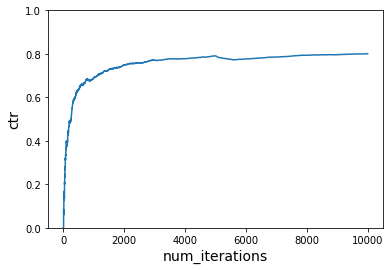

In [408]:
# With learning
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

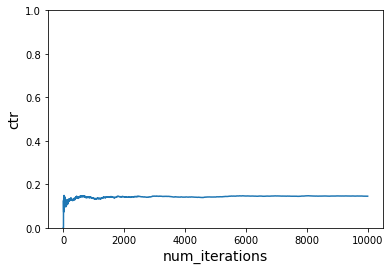

In [409]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

## Modify the second scenario
* Add multiple changes to the reward distribution over time
* Introduce varying noise in the reward distribution

We modify the second scenario by adding the third cost function(i.e.,'get_cost_new2') and adding varying noise in this third reward distribution. 


### Tom

| | `get_cost` | `get_cost_new1` | `get_cost_new2(noisy)` |
|:---|:---:|:---:|:---:|
| **Morning** | Politics | Politics | Finance |
| **Afternoon** | Music | Sports | Sports |

### Anna

| | `get_cost` | `get_cost_new1`  | `get_cost_new2(noisy)` |
|:---|:---:|:---:|:---:|
| **Morning** | Sports | Sports | Sports |
| **Afternoon** | Politics | Sports | Health |



In [410]:
# The third cost function (get_cost_new2)
def get_cost_new2(context,action):
    # Add varying noise in the returned reward
    random_reward = random.choice([USER_LIKED_ARTICLE,USER_DISLIKED_ARTICLE])
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'finance':
            return 0.8*USER_LIKED_ARTICLE+0.2*random_reward
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return 0.8*USER_LIKED_ARTICLE+0.2*random_reward
        else:
            return 0.8*USER_DISLIKED_ARTICLE+0.2*random_reward
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return 0.8*USER_LIKED_ARTICLE+0.2*random_reward
        elif context['time_of_day'] == "afternoon" and action == 'health':
            return 0.8*USER_LIKED_ARTICLE+0.2*random_reward
        else:
            return 0.8*USER_DISLIKED_ARTICLE+0.2*random_reward


## Run different exploration algorithms in the new simulator
In this section we will run the new simulator with the following three different algorithms and compare their performance:

1. Explore-first
2. Epsilon-greedy
3. Softmax-explorer

### 1. Explore-first


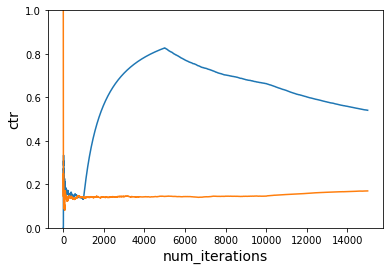

In [411]:
# With learning(Blue curve in the plot)
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 1000")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)



# Do not learn(Orange curve in the plot)
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 1000")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)


### 2. Epsilon-greedy

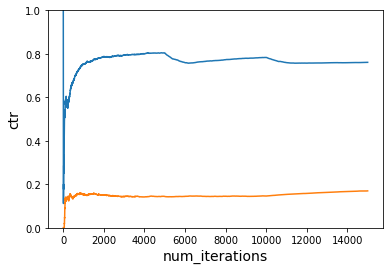

In [412]:
# With learning(Blue curve in the plot)
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)



# Do not learn(Orange curve in the plot)
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)


### 3.  Softmax Explorer

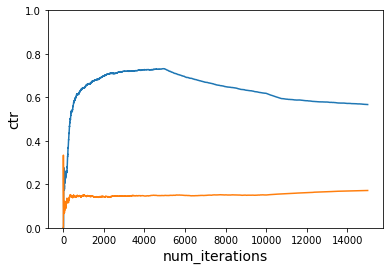

In [413]:
# With learning(Blue curve in the plot)
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 100")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)



# Do not learn(Orange curve in the plot)
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 100")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)


### Comparison:

Comparing the plots of three different exploration algorithms, we could see:

(1) Epsilon-greedy algorithm performs better than the other two when the reward function is introduced noise.

(2) Explore-first algorithm performs worse than the other two when the cost funtion is changed.

(3) The performance of softmax-explorer algorithms is not so stable compared to the other two.
